<h1>Laplace transform</h1>

In [66]:
from mpmath import *
import numpy as np
import sympy
from scipy.integrate import quad #numerical integration
import matplotlib.pyplot as plt

***
### Finding the inverse Laplace transform using `mpmath`

Let $f(t)=te^{-t}$, then its Laplace transform is:
$$\hat{f}(s)=\frac{1}{(s+1)^2}$$

We would make a numerical approximation of this using the `mpmath` package. Lets start by importing the packages and plotting the original function

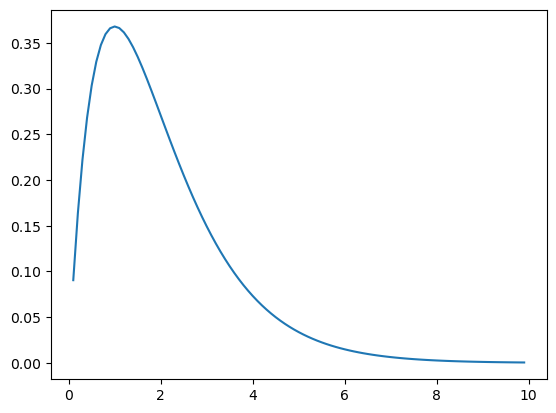

In [67]:
ft = lambda t: t*exp(-t); #Time domain
fs = lambda s: 1/((s+1)**2); #Laplace domain

f=[];
t=np.arange(0.1,10,0.1);
for time in t:
    f.append( ft(time) );
plt.plot(t,f);
plt.show();

Now let's do the same using the inverse Laplace and let's also plot the difference

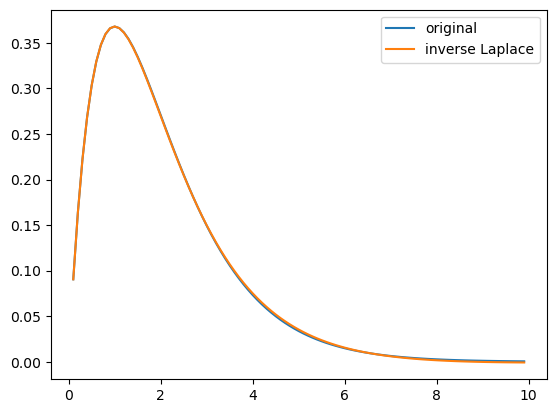

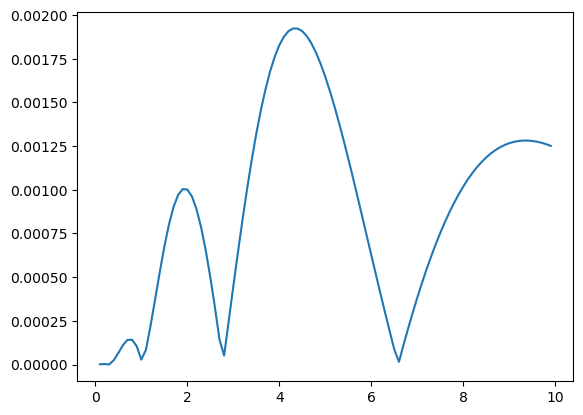

In [68]:
f2=[];
for time in t:
    #Use 7 terms on the coefficient series
    f2.append(invertlaplace(fs,time,method='stehfest',degree=10)); 

plt.plot(t,f,label="original");
plt.plot(t,f2,label="inverse Laplace");
plt.legend();
plt.show();

plt.figure();
diff=np.abs(np.array(f)-np.array(f2));
plt.plot(t,diff,label="difference");
plt.show();


Now let's do that with a sine wave $f(t)=\sin(t)$ (should do worse because of the pole at 0)
$$\hat{f}(s)=\frac{1}{s^2+1}$$

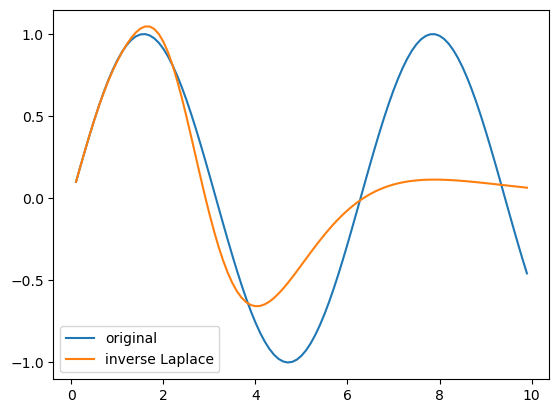

In [4]:
ft = lambda t: sin(t)  #Time domain
fs = lambda s: 1/(s**2+1) #Laplace domain

f=[]; f2=[];
for time in t:
    f.append( ft(time) );
    f2.append(invertlaplace(fs,time,method='stehfest',degree=10));

plt.plot(t,f,label="original");
plt.plot(t,f2,label="inverse Laplace");
plt.legend();
plt.show();

plt.figure();
diff=np.abs(np.array(f)-np.array(f2));
plt.plot(t,diff,label="difference");


Finally, let's do this with some data for the inverse laplace transform.

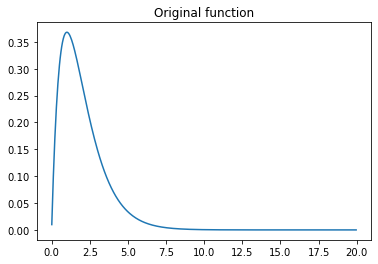

In [11]:
# Making up some data for the concentrations at nodes
timeseries=[];
delta=1/100;
t=0;
times=[];
for i in range(1000):
    if i<200:
        timeseries.append((t/5)**2);
    elif i<500:
        timeseries.append((3-t/2));
    else:
        timeseries.append(1);
    times.append(t);
    t=t+delta;

#plt.plot(times,timeseries);

#index from time
t2index=lambda t: round(t/delta);

#the actual function
"""def dataft(t):
    if t<0: 
        return 0;
    if t<=(1000-1)*delta:
        ind=t2index(t);
        return timeseries[ind];
    return 0;
"""#exact test ft
dataft = lambda t: t*exp(-t); 

times=np.arange(delta,2*(1000-1)*delta,0.05);
values=[dataft(t) for t in times];
plt.plot(times,values);
plt.title("Original function");
plt.show();

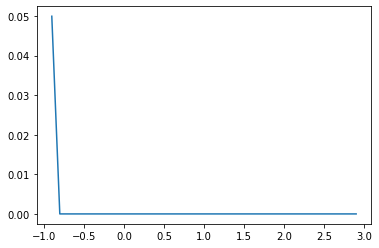

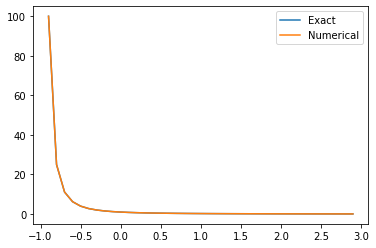

In [15]:
#Now we need an approximate Laplace for ft
Ldomain=np.arange(-0.9,3,0.1);

def datafs(s):
    integrand=lambda t:exp(-s*t)*dataft(t);
    integral,_=quad(integrand,0,100);
    return integral;

#difference between the exact Laplace and the calculated one
exactfs = lambda s: 1/((s+1)**2);
diff=[ exactfs(s)-datafs(s) for s in Ldomain ];

Ls=[datafs(s) for s in Ldomain];
plt.figure();
plt.plot(Ldomain, diff);
plt.show();

plt.figure();
plt.plot(Ldomain, [ exactfs(s) for s in Ldomain ], label="Exact");
plt.plot(Ldomain, [ datafs(s) for s in Ldomain ], label="Numerical");
plt.legend();
plt.show();

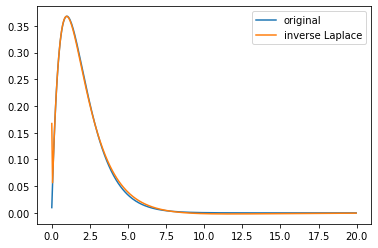

In [14]:
f=[]; f2=[];
for time in times:
    f.append( dataft(time) );
    f2.append(invertlaplace(datafs,time,method='stehfest',degree=7));

plt.plot(times,f,label="original");
plt.plot(times,f2,label="inverse Laplace");
plt.legend();
plt.show();


***
### My own Inverse Laplace implementation using GS and Laguerre for Laplace transform

We need an efficient factorial/binomial calculation, so lets test the 3 common ways of doing it.

In [19]:
import scipy.special
import timeit
import math

def testbinom(n, function):
    Sum=0;
    for k in range(n+1):
        Sum+=function(n,k);
    return(Sum);

setup="""
import scipy.special
import math

def testbinom(n, function):
    Sum=0;
    for k in range(n+1):
        Sum+=function(n,k);
    return(Sum);

n=10;
"""

print(timeit.timeit(setup=setup, stmt="testbinom(n,math.comb)",number=10000));

print(timeit.timeit(setup=setup, stmt="testbinom(n,scipy.special.binom)",number=10000));

print(timeit.timeit(setup=setup, stmt="testbinom(n,scipy.special.comb)",number=10000));




0.02273460000014893
0.13845019999916985
0.4750770000000557
1.6094379124341003


Testing shows that on values $n<20$ the `math` implementation performs better.

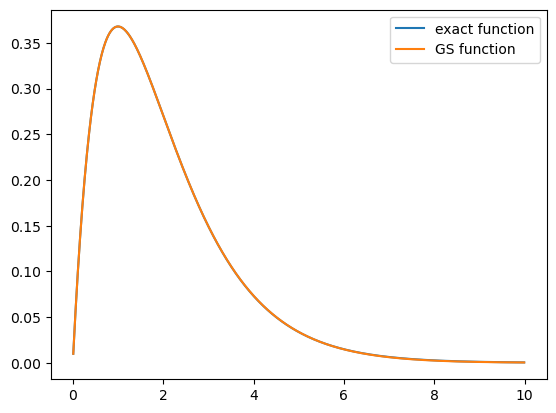

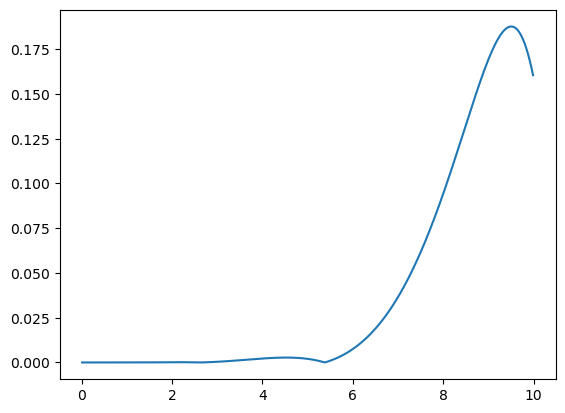

In [100]:
import math
import numpy as np
import matplotlib.pyplot as plt


def GSinverse(t, Qs, omega):
    """
    My own implementation of GS method. omega must be an even integer, 
    t>0, and Qs the Laplace transform function.
    """
    #finding the kappa coefficients
    if(t==0 or omega%2!=0):
        raise(ValueError("t=0 is not a valid input and omega must be even"));
    kappa=[0]*(omega+1);
    for n in range (1,omega+1):
        omega2=omega//2;
        sign= 1 if ((n+omega2)%2==0) else -1;
        lowK=math.floor((n+1)/2);
        highK=min(n,omega2);
        Sum=0;
        for k in range(lowK,highK+1):
            summand=k**(omega2)/(math.factorial(omega2-k)*math.factorial(k-1));
            summand=summand*(math.comb(2*k, k)*math.comb(k,n-k));
            Sum=Sum+summand;
        kappa[n]=sign*Sum;
    #Computing the inverse Laplace at t
    log2t=math.log(2)/t;
    qt=0;
    for n in range(1,omega+1):
        qt=qt+kappa[n]*(Qs(n*log2t));
    qt=log2t*qt;
    return qt;

#----------testing it out-----------#
fs = lambda s: 1/(s+1)**2
ft = lambda t: t*math.exp(-t)

delta=0.01;
t=np.arange(delta,10,delta)

exactf=np.array([ft(time) for time in t]);

f=np.zeros(len(t));
for i in range(len(t)):
    time=delta*(i+1);
    f[i]=GSinverse(time,fs,14);


plt.plot(t,exactf,label="exact function");
plt.plot(t,f,label="GS function");
plt.legend();
plt.show();

plt.figure();
plt.plot(t,[abs((f[i]-exactf[i])/f[i]) for i in range(len(f))]);
plt.show();
#----------End of the test-----------#

Now we compare two different methods to compute the laguerre roots. Since the roots are only computed once, then we care about the precision of the method itself.

In [84]:
from sympy import *
import scipy
import math

def lag_weights_roots(n):
    x = Symbol("x")
    roots = Poly(laguerre(n, x)).all_roots()
    x_i = [rt.evalf(20) for rt in roots]
    w_i = [(rt / ((n + 1) * laguerre(n + 1, rt)) ** 2).evalf(20) for rt in roots]
    return x_i, w_i


def f(x):
    return 5*x*x*x*x*x-3*x*x+1;

N=[3,5,9,15];
for n in N:
    integral=0; integral2=0;
    xi,wi=lag_weights_roots(n);
    xi2,wi2=scipy.special.roots_genlaguerre(n,0);
    for i in range(n):
        integral= integral +wi[i]*f(xi[i]);
        integral2= integral2 +wi2[i]*f(xi2[i]);
    print(f"for n={n}");
    print(integral-595);
    print(integral2-595);

for n=3
-8.6736173798840354721e-19
-6.821210263296962e-13
for n=5
0
5.684341886080801e-13
for n=9
0
-3.410605131648481e-13
for n=15
0
1.1368683772161603e-13


We see that `scipy` has a better precision but the 12 digits precision of sympy is not really an issue. Now, let's actually calculate some Laplace transforms using this.

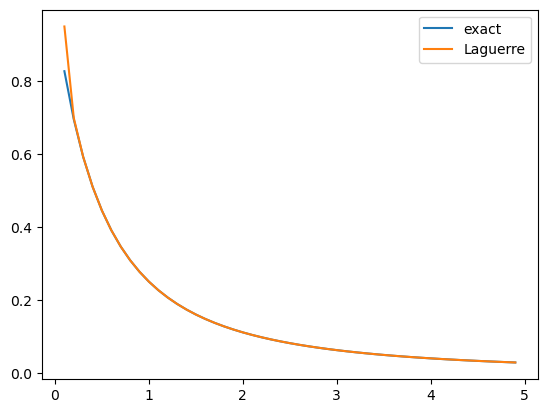

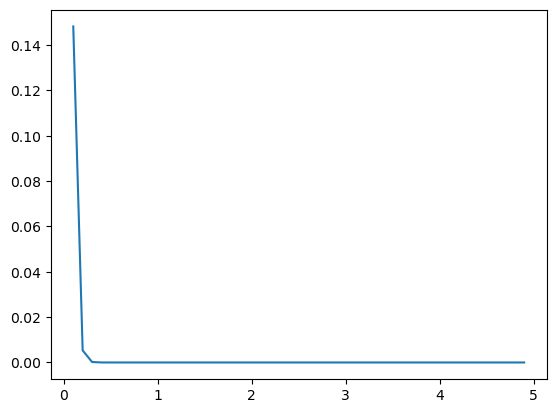

In [103]:
from sympy import *
import math

def lag_weights_roots(n):
    x = Symbol("x")
    roots = Poly(laguerre(n, x)).all_roots()
    x_i = [rt.evalf(20) for rt in roots]
    w_i = [(rt / ((n + 1) * laguerre(n + 1, rt)) ** 2).evalf(20) for rt in roots]
    return x_i, w_i

#number of roots to use
n=14;
xi,wi=lag_weights_roots(n);

#Laplace trasform using laguerre polynomials
def Laplace(s,qt):
    newqt= lambda t: qt(t/s)/s;
    integral=0;
    for i in range(n):
        integral=integral+wi[i]*newqt(xi[i]);
    return integral;

fs = lambda s: 1/(s+1)**2
ft = lambda t: t*math.exp(-t)

delta=0.1;
srange=np.arange(delta,5,delta);
#exact
fs_exact=np.array( [fs(s) for s in srange]  );
#approx using Laguerre
fs_lag=np.array( [Laplace(delta*(i+1),ft) for i in range(len(srange))]  );

plt.plot(srange,fs_exact,label="exact");
plt.plot(srange,fs_lag,label="Laguerre");
plt.legend();
plt.show();

plt.figure();
plt.plot(srange,abs((fs_exact-fs_lag)/fs_exact));
plt.show();



***
<h3>Applying Laplace transform to initial flow/concentration conditions</h3>

say we have some the initial conditions for the concentration at the nodes $q_{ij}(0,t)$ for every $i,j$. Then to solve the system we require the Laplace transform of the initial conditions. To do so, we 